<a href="https://colab.research.google.com/github/Bharathkumar1404/data-science-final-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import pandas as pd
import numpy as np

In [147]:
!pip install matplotlib

In [3]:
!pip install prophet

In [4]:
!pip install statsmodels

In [5]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Flatten
#from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [6]:
weather_data = pd.read_csv('pune.csv')
weather_data.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2008-12-11 00:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,10,31,72,0.0,1013,18,10,114,5,pune
1,2008-12-11 01:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,9,30,72,0.0,1013,19,10,125,4,pune
2,2008-12-11 02:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,8,29,72,0.0,1013,18,10,136,4,pune
3,2008-12-11 03:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,8,29,72,0.0,1013,18,10,147,4,pune
4,2008-12-11 04:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,7,23,68,0.0,1014,20,10,136,4,pune


In [7]:
wf = weather_data.drop(columns=['DewPointC','cloudcover','moonrise', 'moonset', 'sunrise', 'sunset','sunHour','totalSnow_cm','uvIndex','moon_illumination','visibility','winddirDegree','windspeedKmph'])

In [8]:
wf.head()

,date_time,maxtempC,mintempC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,humidity,precipMM,pressure,tempC,location
0,2008-12-11 00:00:00,30,18,18,18,18,10,72,0.0,1013,18,pune
1,2008-12-11 01:00:00,30,18,19,19,19,9,72,0.0,1013,19,pune
2,2008-12-11 02:00:00,30,18,18,18,18,8,72,0.0,1013,18,pune
3,2008-12-11 03:00:00,30,18,18,18,18,8,72,0.0,1013,18,pune
4,2008-12-11 04:00:00,30,18,20,20,20,7,68,0.0,1014,20,pune


In [9]:
wf['date_time'] = pd.to_datetime(wf['date_time'])
wf['year'] = wf['date_time'].dt.year
wf['month'] = wf['date_time'].dt.month
wf['day'] = wf['date_time'].dt.day
wf['hour'] = wf['date_time'].dt.hour

wf = wf[wf['year'] > 2008]
wf = wf[wf['year'] < 2022]

In [10]:
wf = wf.reset_index(drop= True)

In [11]:
print(wf.info())
print(wf.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_time     113952 non-null  datetime64[ns]
 1   maxtempC      113952 non-null  int64         
 2   mintempC      113952 non-null  int64         
 3   FeelsLikeC    113952 non-null  int64         
 4   HeatIndexC    113952 non-null  int64         
 5   WindChillC    113952 non-null  int64         
 6   WindGustKmph  113952 non-null  int64         
 7   humidity      113952 non-null  int64         
 8   precipMM      113952 non-null  float64       
 9   pressure      113952 non-null  int64         
 10  tempC         113952 non-null  int64         
 11  location      113952 non-null  object        
 12  year          113952 non-null  int32         
 13  month         113952 non-null  int32         
 14  day           113952 non-null  int32         
 15  hour          113

In [12]:
missing_values = wf.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 date_time       0
maxtempC        0
mintempC        0
FeelsLikeC      0
HeatIndexC      0
WindChillC      0
WindGustKmph    0
humidity        0
precipMM        0
pressure        0
tempC           0
location        0
year            0
month           0
day             0
hour            0
dtype: int64


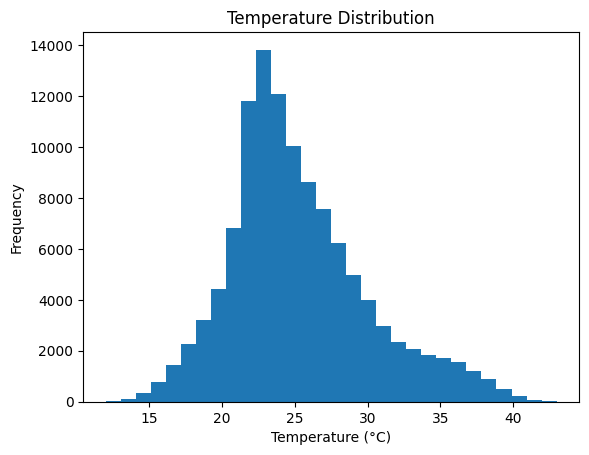

In [13]:
wf['tempC'].plot(kind='hist', bins=30, title='Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.show()

year
2009    25.416210
2010    24.967808
2011    25.084817
2012    25.401753
2013    25.117009
2014    25.387100
2015    25.354566
2016    25.123634
2017    25.451027
2018    25.830023
2019    25.528311
2020    25.433629
2021    25.333219
Name: tempC, dtype: float64


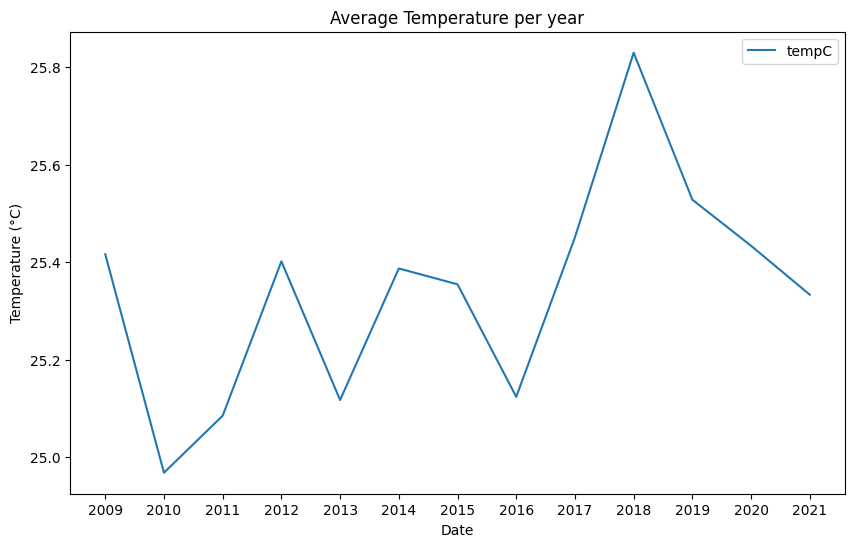

In [14]:
wf = wf.sort_values(by='date_time')
wfg = wf.groupby('year')['tempC'].mean()
print(wfg)

wfg = wfg.reset_index()
wfg.plot(x='year', y='tempC', kind='line', figsize=(10, 6))

plt.xticks(wfg['year'].unique())
plt.title('Average Temperature per year')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()


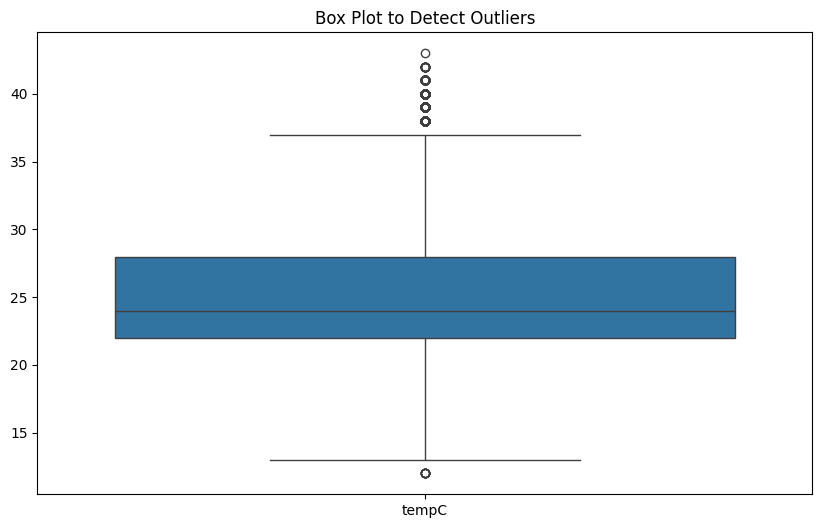

Number of outliers in Temperature: 1718
Original DataFrame shape: (113952, 16)
        year  tempC
1356    2009     38
1357    2009     38
1358    2009     38
1380    2009     38
1381    2009     38
...      ...    ...
107942  2021     39
107943  2021     39
107944  2021     39
107965  2021     38
107966  2021     38

[1718 rows x 2 columns]


In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=wf[['tempC']])#, 'humidity']])
plt.title('Box Plot to Detect Outliers')
plt.show()

Q1 = wf['tempC'].quantile(0.25)
Q3 = wf['tempC'].quantile(0.75)
IQR = Q3 - Q1

#Q5 = wf['humidity'].quantile(0.25)
#Q7 = wf['humidity'].quantile(0.75)
#IQR1 = Q7 - Q5

outliers_tempC = wf[(wf['tempC'] < (Q1 - 1.5 * IQR)) | (wf['tempC'] > (Q3 + 1.5 * IQR))]

#outliers_humidity = wf[(wf['humidity'] < (Q5 - 1.5 * IQR)) | (wf['humidity'] > (Q7 + 1.5 * IQR))]

print("Number of outliers in Temperature:", len(outliers_tempC))
#print("Number of outliers in Humidity:", len(outliers_humidity))
print("Original DataFrame shape:", wf.shape)
print(outliers_tempC[['year', 'tempC']])
#print(outliers_humidity[['year', 'humidity']])



Original DataFrame shape: (113952, 16)
DataFrame without outliers shape: (112234, 16)
Number of outliers in Temperature: 112234
            date_time  maxtempC  mintempC  FeelsLikeC  HeatIndexC  WindChillC  \
0 2009-01-01 00:00:00        31        17          17          17          17   
1 2009-01-01 01:00:00        31        17          17          17          17   
2 2009-01-01 02:00:00        31        17          17          17          17   
3 2009-01-01 03:00:00        31        17          17          17          17   
4 2009-01-01 04:00:00        31        17          17          17          17   

   WindGustKmph  humidity  precipMM  pressure  tempC location  year  month  \
0             7        50       0.0      1013     17     pune  2009      1   
1             9        46       0.0      1013     17     pune  2009      1   
2            10        43       0.0      1013     17     pune  2009      1   
3            12        40       0.0      1013     17     pune  2009      

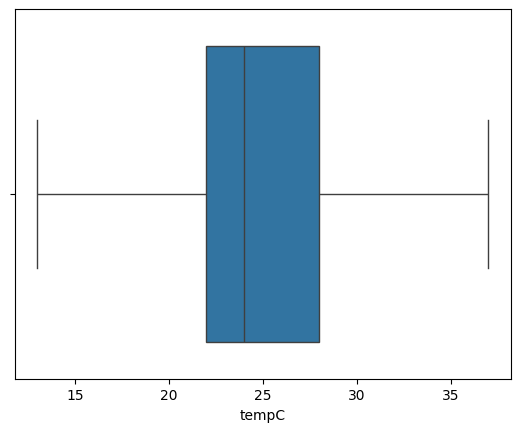

In [16]:
wf_no_outliers = wf[(wf['tempC'] >= (Q1 - 1.5 * IQR)) & (wf['tempC'] <= (Q3 + 1.5 * IQR))]
wf_no_outliers.tail()

print("Original DataFrame shape:", wf.shape)
print("DataFrame without outliers shape:", wf_no_outliers.shape)

sns.boxplot(x=wf_no_outliers['tempC'])
print("Number of outliers in Temperature:", len(wf_no_outliers))
print(wf_no_outliers.head())

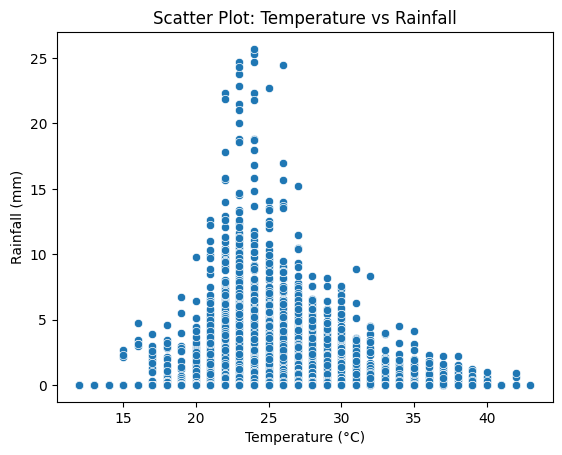

          tempC  precipMM
year                     
2009  25.416210  0.262340
2010  24.967808  0.269829
2011  25.084817  0.236416
2012  25.401753  0.155886
2013  25.117009  0.245959
2014  25.387100  0.207591
2015  25.354566  0.154749
2016  25.123634  0.259791
2017  25.451027  0.265982
2018  25.830023  0.188276
2019  25.528311  0.317146
2020  25.433629  0.302209
2021  25.333219  0.202489


In [17]:
sns.scatterplot(x='tempC', y='precipMM', data=wf)
plt.title('Scatter Plot: Temperature vs Rainfall')
plt.xlabel('Temperature (°C)')
plt.ylabel('Rainfall (mm)')
plt.show()

wfs =wf.groupby('year')[['tempC','precipMM']].mean()
print(wfs)


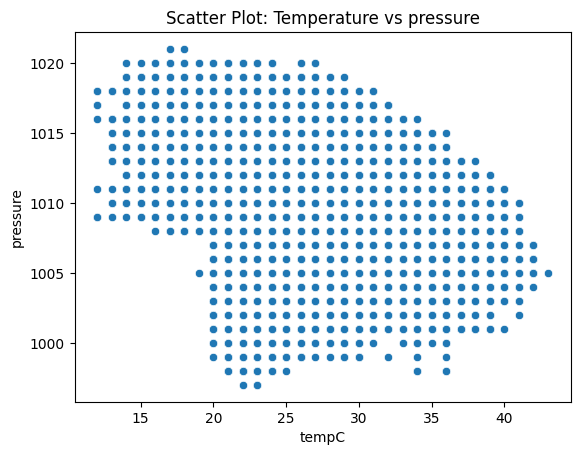

In [18]:
sns.scatterplot(x='tempC', y='pressure', data=wf)
plt.title("Scatter Plot: Temperature vs pressure")
plt.show()


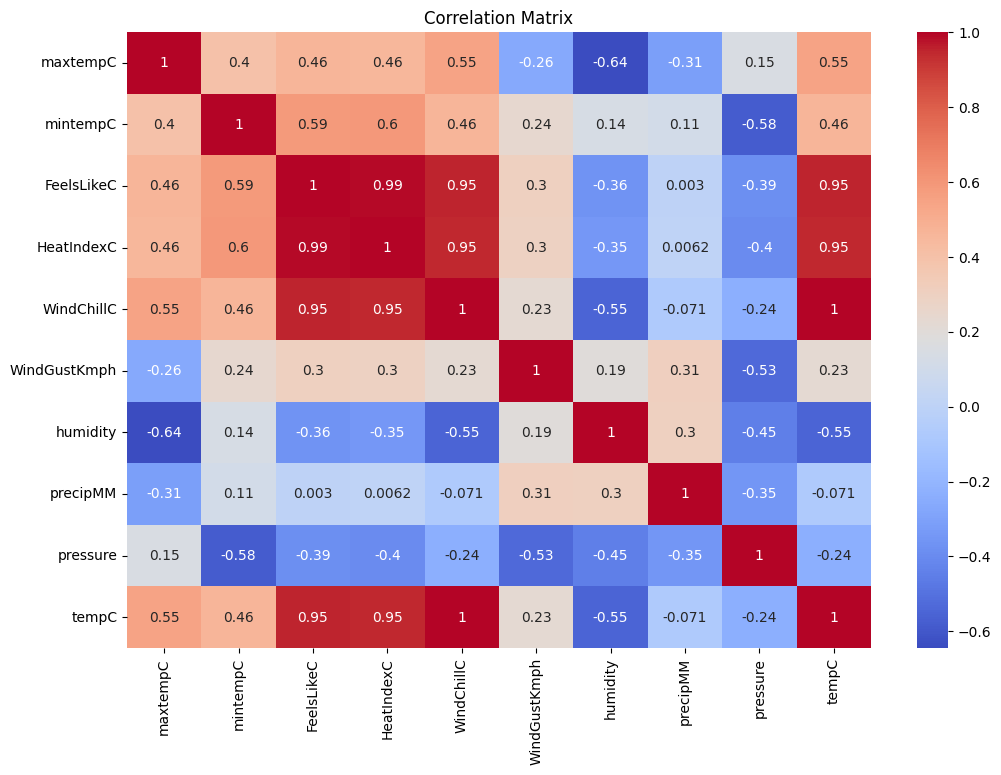

In [19]:
numeric_data = wf.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [20]:
wf_no_outliers.set_index('date_time', inplace=True)

wf_daily_data = wf_no_outliers[['tempC', 'humidity', 'pressure']].resample('D').mean()

print(wf_daily_data.head(30))

wf_daily_data.tail()

                tempC   humidity     pressure
date_time                                    
2009-01-01  22.541667  37.875000  1012.791667
2009-01-02  22.125000  44.000000  1013.750000
2009-01-03  22.583333  47.791667  1014.708333
2009-01-04  22.208333  52.791667  1013.583333
2009-01-05  22.458333  51.833333  1011.791667
2009-01-06  22.250000  47.583333  1011.833333
2009-01-07  22.041667  40.125000  1012.666667
2009-01-08  22.958333  42.541667  1014.458333
2009-01-09  22.875000  54.625000  1015.625000
2009-01-10  23.875000  54.708333  1014.958333
2009-01-11  24.541667  44.666667  1015.000000
2009-01-12  24.416667  43.208333  1016.916667
2009-01-13  23.250000  40.791667  1018.166667
2009-01-14  23.666667  37.125000  1018.416667
2009-01-15  23.500000  36.791667  1017.541667
2009-01-16  23.500000  38.166667  1017.083333
2009-01-17  23.291667  41.208333  1015.583333
2009-01-18  23.750000  40.250000  1014.375000
2009-01-19  24.166667  35.500000  1014.208333
2009-01-20  24.041667  29.750000  

,tempC,humidity,pressure
date_time,,,
2021-12-27,23.083333,44.208333,1014.708333
2021-12-28,22.833333,53.500000,1013.750000
2021-12-29,21.250000,53.333333,1014.083333
2021-12-30,21.250000,54.458333,1015.666667
2021-12-31,22.625000,48.416667,1016.333333


In [44]:
# convert float to integer
wf_daily_data['tempC'] = wf_daily_data['tempC'].astype(int)
wf_daily_data['humidity'] = wf_daily_data['humidity'].astype(int)
wf_daily_data['pressure'] = wf_daily_data['pressure'].astype(int)
# print data types
print(wf_daily_data.dtypes)

tempC       int64
humidity    int64
pressure    int64
time_idx    int64
group       int64
dtype: object


In [45]:
wf_daily_data.to_csv('out.csv', index=False)

In [41]:
print(wf_daily_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4748 entries, 2009-01-01 to 2021-12-31
Freq: D
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tempC     4748 non-null   float64
 1   humidity  4748 non-null   float64
 2   pressure  4748 non-null   float64
 3   time_idx  4748 non-null   int64  
 4   group     4748 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 222.6 KB
None


In [22]:
wf.head()

,date_time,maxtempC,mintempC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,humidity,precipMM,pressure,tempC,location,year,month,day,hour
0,2009-01-01 00:00:00,31,17,17,17,17,7,50,0.0,1013,17,pune,2009,1,1,0
1,2009-01-01 01:00:00,31,17,17,17,17,9,46,0.0,1013,17,pune,2009,1,1,1
2,2009-01-01 02:00:00,31,17,17,17,17,10,43,0.0,1013,17,pune,2009,1,1,2
3,2009-01-01 03:00:00,31,17,17,17,17,12,40,0.0,1013,17,pune,2009,1,1,3
4,2009-01-01 04:00:00,31,17,17,17,17,11,38,0.0,1013,17,pune,2009,1,1,4


preprocessing

               tempC  humidity  pressure  temp_lag_1  humidity_lag_1
date_time                                                           
2009-01-01  0.314108  0.313762  0.711934         NaN             NaN
2009-01-02  0.283612  0.382809  0.759259    0.314108        0.313762
2009-01-03  0.317157  0.425552  0.806584    0.283612        0.382809
2009-01-04  0.289711  0.481916  0.751029    0.317157        0.425552
2009-01-05  0.308008  0.471113  0.662551    0.289711        0.481916


<ipython-input-157-1a7530d4818b>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wf_daily_data.fillna(method = 'bfill',inplace=True)


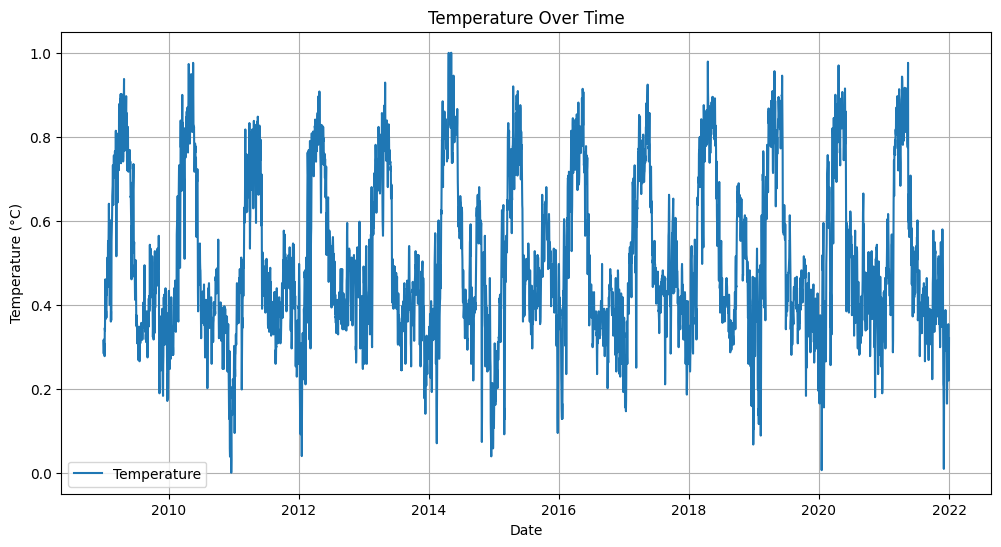

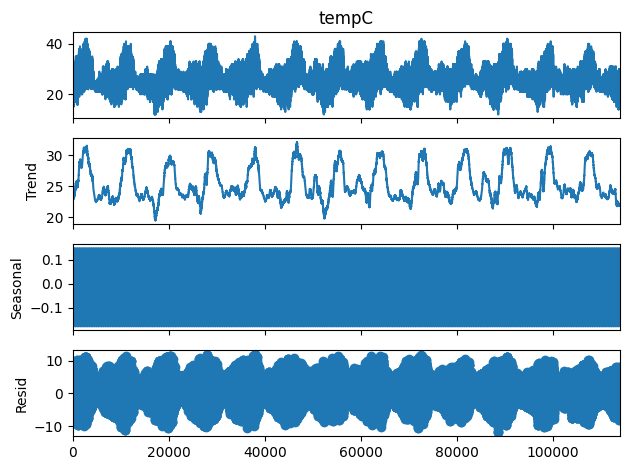

In [ ]:
scaler = MinMaxScaler()
wf_daily_data[['tempC', 'humidity', 'pressure']] = scaler.fit_transform(wf_daily_data[['tempC', 'humidity', 'pressure']])

wf_daily_data['temp_lag_1'] = wf_daily_data['tempC'].shift(1)
wf_daily_data['humidity_lag_1'] = wf_daily_data['humidity'].shift(1)
print(wf_daily_data.head())

wf_daily_data.fillna(method = 'bfill',inplace=True)
wf_daily_data.head()

train = wf_daily_data[wf_daily_data.index <= pd.to_datetime('2019-01-01')]
test = wf_daily_data[wf_daily_data.index > pd.to_datetime('2019-01-01')]

plt.figure(figsize=(12, 6))
plt.plot(wf_daily_data.index,wf_daily_data['tempC'], label='Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

result = seasonal_decompose(wf['tempC'], model='additive', period=365)
result.plot()
plt.show()

ARIMA MODEL

In [ ]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

check_stationarity(wf['tempC'])

ADF Statistic: -8.60181633817182
p-value: 6.836621222378553e-14
The series is stationary.


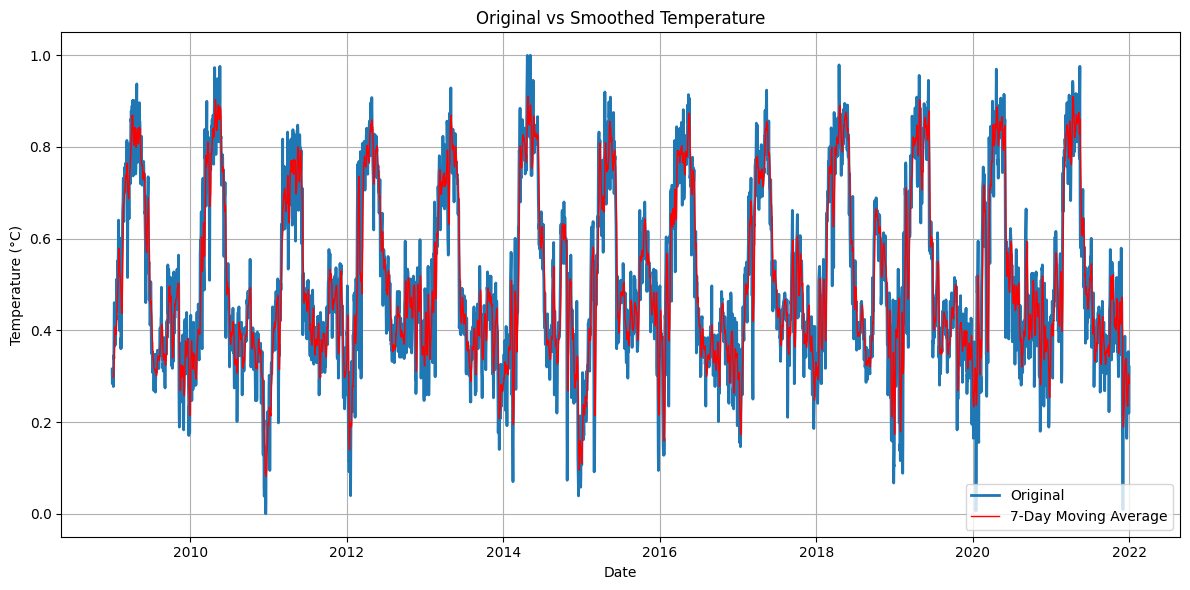

<Figure size 1200x600 with 0 Axes>

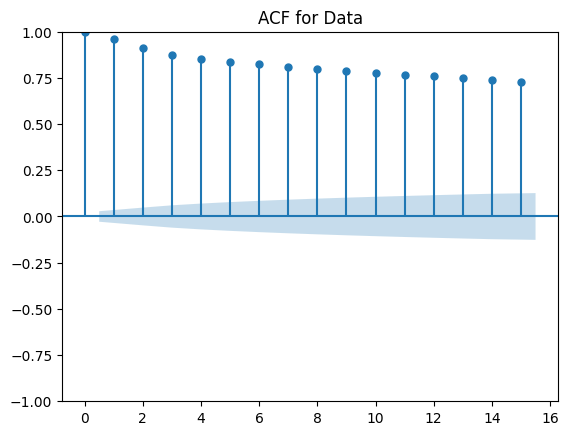

<Figure size 1200x600 with 0 Axes>

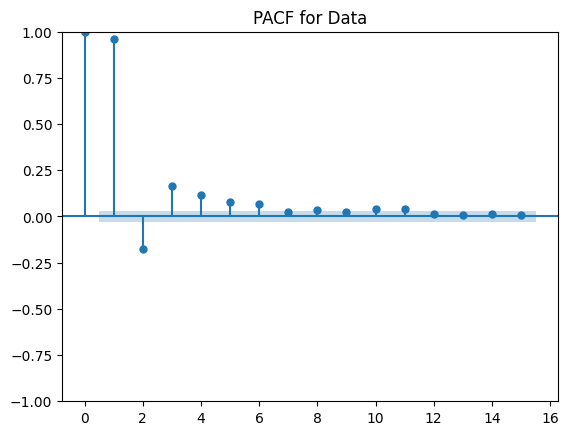

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5874.677, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1201.394, Time=0.43 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-11563.109, Time=0.42 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-11574.910, Time=3.16 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.56 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-11796.584, Time=5.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=1.67 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-11792.329, Time=3.30 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-11797.274, Time=2.35 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-11544.991, Time=4.78 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-11795.747, Time=5.98 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-11798.559, Time=2.90 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-11800.549, Time=1.50 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-11763.905, Time=1.04 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-11798.350, Time=6.37 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-11609.923, Time=1.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-11790.812, Time=1.72 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-11796.810, Time=3.39 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-11808.821, Time=10.34 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-11791.086, Time=6.25 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-11772.086, Time=10.07 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-11800.500, Time=9.20 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-11810.885, Time=10.74 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-11812.332, Time=11.14 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=-10037.509, Time=3.92 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,5)(0,0,0)[0] intercept   : AIC=-11820.322, Time=12.59 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=-10408.820, Time=9.66 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=-11818.221, Time=12.80 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,5)(0,0,0)[0]             : AIC=-11801.206, Time=4.70 sec

Best model:  ARIMA(1,0,5)(0,0,0)[0] intercept
Total fit time: 147.581 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3653
Model:               SARIMAX(1, 0, 5)   Log Likelihood                5918.161
Date:                Wed, 01 Jan 2025   AIC                         -11820.322
Time:                        19:16:34   BIC                         -11770.696
Sample:                    01-01-2009   HQIC                        -11802.650
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0064      0.002      3.882      0.000       0.

In [ ]:

temperature_rolling = wf_daily_data['tempC'].rolling(window=7).mean()


plt.figure(figsize=(12, 6))
plt.plot(wf_daily_data.index, wf_daily_data['tempC'], label='Original', linewidth=2)
plt.plot(wf_daily_data.index, temperature_rolling, label='7-Day Moving Average', color='red', linewidth=1)
plt.title('Original vs Smoothed Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(wf_daily_data['tempC'], lags=15)
plt.title('ACF for Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(wf_daily_data['tempC'], lags=15)
plt.title('PACF for Data')
plt.show()

!pip install pmdarima
from pmdarima import auto_arima

auto_model = auto_arima(train['tempC'],
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        d=None,
                        seasonal=False,
                        stepwise=True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        max_order=None,
                        information_criterion='aic'
                        )


print(auto_model.summary())


In [ ]:
model = ARIMA(train['tempC'], order=(1, 0, 5),exog=train[['humidity', 'pressure','temp_lag_1','humidity_lag_1']])
model_fit = model.fit()

print(model_fit.summary())

forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps,exog=test[['humidity', 'pressure','temp_lag_1','humidity_lag_1']])

forecast_index = pd.date_range(start=test.index[0] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

                               SARIMAX Results                                
Dep. Variable:                  tempC   No. Observations:                 3653
Model:                 ARIMA(1, 0, 5)   Log Likelihood                6254.373
Date:                Wed, 01 Jan 2025   AIC                         -12484.747
Time:                        19:17:38   BIC                         -12410.307
Sample:                    01-01-2009   HQIC                        -12458.238
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0285      0.006      4.582      0.000       0.016       0.041
humidity          -0.3458      0.009    -37.760      0.000      -0.364      -0.328
pressure          -0.0157      0.005

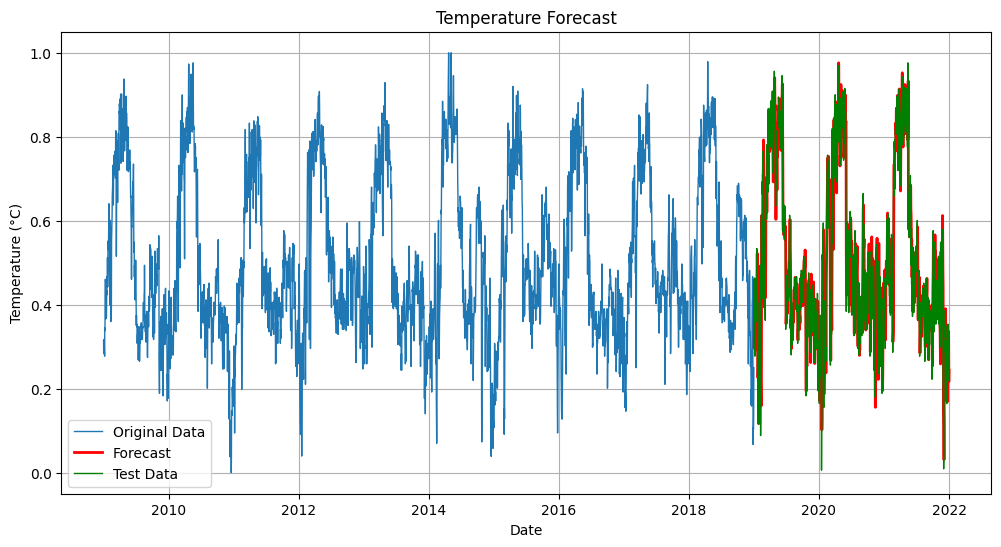

,predicted_mean
2019-01-02,0.298763
2019-01-03,0.397193
2019-01-04,0.453835
2019-01-05,0.430136
2019-01-06,0.459903
...,...
2021-12-27,0.323369
2021-12-28,0.320188
2021-12-29,0.336707
2021-12-30,0.216610


In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['tempC'], label='Original Data', linewidth=1)
plt.plot(forecast_index, forecast, label='Forecast', color='red', linewidth=2)
plt.plot(test.index, test['tempC'], label='Test Data', color='green', linewidth=1)
plt.title('Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()
forecast


In [ ]:
mae = mean_absolute_error(test['tempC'], forecast)
print("MAE:", mae)
rmse = np.sqrt(mean_squared_error(test['tempC'], forecast))
print("RMSE:", rmse)
r2 = r2_score(test['tempC'], forecast)
print("R²:", r2)


MAE: 0.03885784261677378
RMSE: 0.05172359709117648
R²: 0.9290799870371329


FACEBOOK PROPHET MODEL

In [ ]:
wf_pro = pd.DataFrame(train)
wf_pro.drop(columns=['temp_lag_1', 'humidity_lag_1'],inplace = True)
wf_pro['ds'] = pd.to_datetime(train.index)
wf_pro['y'] = train['tempC']
wf_pro.head()

,tempC,humidity,pressure,ds,y
date_time,,,,,
2009-01-01,0.314108,0.313762,0.711934,2009-01-01,0.314108
2009-01-02,0.283612,0.382809,0.759259,2009-01-02,0.283612
2009-01-03,0.317157,0.425552,0.806584,2009-01-03,0.317157
2009-01-04,0.289711,0.481916,0.751029,2009-01-04,0.289711
2009-01-05,0.308008,0.471113,0.662551,2009-01-05,0.308008


In [ ]:
wf_pro_test = pd.DataFrame(test)
wf_pro_test.drop(columns=['temp_lag_1', 'humidity_lag_1'],inplace = True)
wf_pro_test['ds'] = pd.to_datetime(test.index)
wf_pro_test['y'] = test['tempC']
wf_pro_test.head()

,tempC,humidity,pressure,ds,y
date_time,,,,,
2019-01-02,0.399496,0.139502,0.969136,2019-01-02,0.399496
2019-01-03,0.460488,0.171442,0.977366,2019-01-03,0.460488
2019-01-04,0.457438,0.194457,0.915638,2019-01-04,0.457438
2019-01-05,0.463538,0.267262,0.843621,2019-01-05,0.463538
2019-01-06,0.433042,0.273837,0.802469,2019-01-06,0.433042


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppvy8jwku/bz0ztfss.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppvy8jwku/p4ycg775.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63288', 'data', 'file=/tmp/tmppvy8jwku/bz0ztfss.json', 'init=/tmp/tmppvy8jwku/p4ycg775.json', 'output', 'file=/tmp/tmppvy8jwku/prophet_model0iu5zq6w/prophet_model-20250101191740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:17:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:17:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


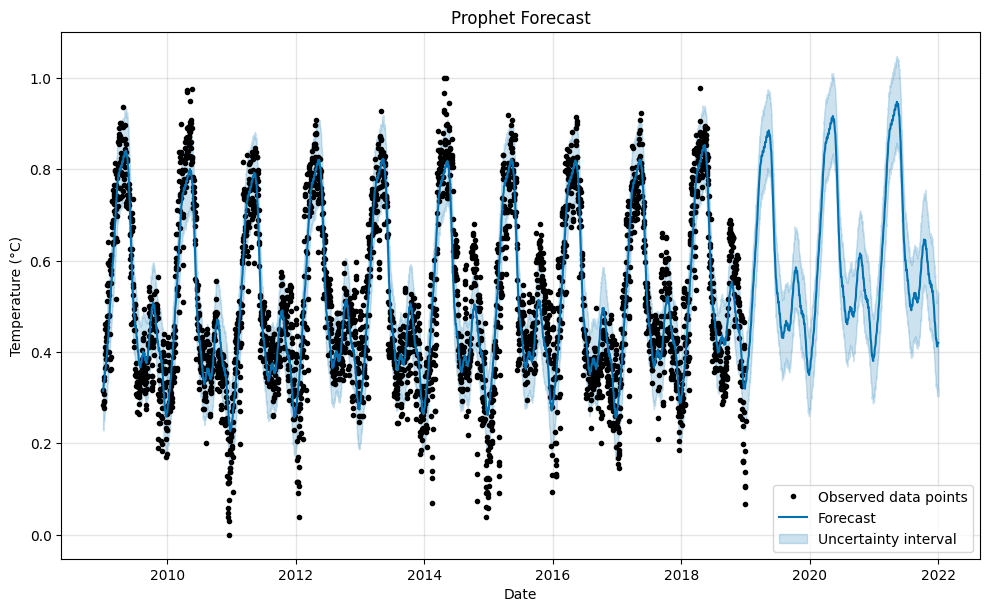

In [ ]:
model = Prophet(interval_width = 0.68)
model.fit(wf_pro)
forecast_steps=len(wf_pro_test)
future = model.make_future_dataframe(periods=forecast_steps,freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper', 'trend','trend_lower', 'trend_upper']].tail()
y_true = wf_pro_test['y'].values  # Replace 'y' with your target column name
y_pred = forecast['yhat'][-len(wf_pro_test):].values
wf_prophet = pd.concat([wf_pro,wf_pro_test])
prophet_plot_1 = model.plot(forecast, include_legend=True)
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

In [ ]:
wf_prophet.shape

(4748, 5)

In [ ]:
forecast.shape

(4748, 19)

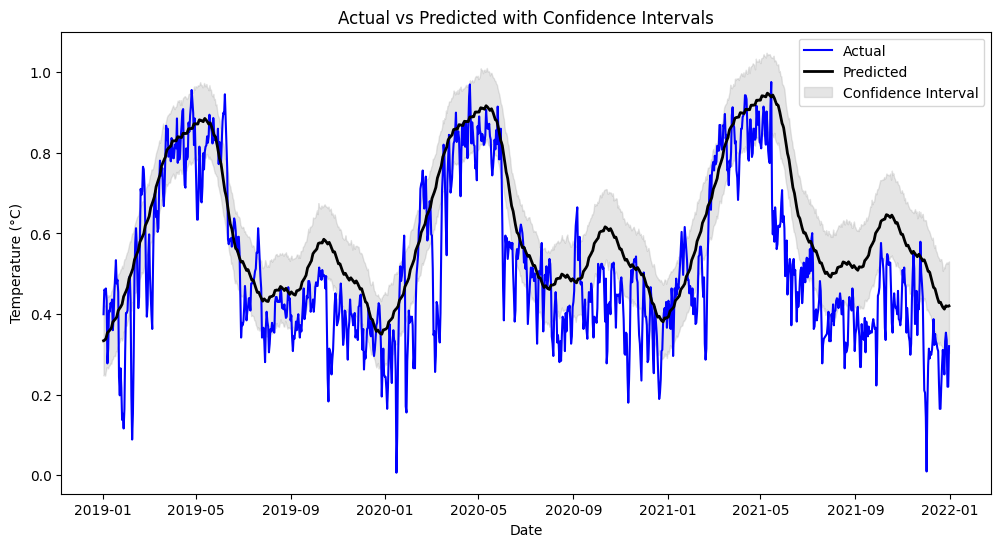

,yhat
0,0.315210
1,0.316811
2,0.317898
3,0.325700
4,0.332393
...,...
4743,0.420491
4744,0.419497
4745,0.419508
4746,0.419025


In [ ]:
# Merge actual and forecasted data
forecast_actual = pd.merge(wf_pro_test, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(forecast_actual['ds'], forecast_actual['y'], label='Actual', color='blue')
plt.plot(forecast_actual['ds'], forecast_actual['yhat'], label='Predicted', color='black',linewidth=2)
plt.fill_between(forecast_actual['ds'],
                 forecast_actual['yhat_lower'],
                 forecast_actual['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title("Actual vs Predicted with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()
forecast['yhat']

In [ ]:
wf_prophet.shape

(4748, 5)

In [ ]:
forecast.shape

(4748, 19)

In [ ]:
# code
print("Mean Squared Error (MSE):", mean_squared_error(y_true = wf_prophet["y"], y_pred = forecast['yhat']))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = wf_prophet["y"], y_pred = forecast['yhat']))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_true = wf_prophet["y"], y_pred = forecast['yhat'])))
print("R-squared (R²):", r2_score(y_true = wf_prophet["y"], y_pred = forecast['yhat']))

Mean Squared Error (MSE): 0.01033875237726779
Mean Absolute Error (MAE): 0.07694384078749658
Root Mean Squared Error (RMSE): 0.10167965567048204
R-squared (R²): 0.715476457799989


cnn_lstm

(3563, 90, 4)
(3563,)
(1005, 90, 4)
(1005,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 86, 128)             │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,389 (368.71 KB)

 Trainable params: 94,389 (368.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - loss: 0.0449 - mae: 0.1428 - val_loss: 0.0095 - val_mae: 0.0732
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0081 - mae: 0.0686 - val_loss: 0.0093 - val_mae: 0.0719
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0072 - mae: 0.0643 - val_loss: 0.0086 - val_mae: 0.0699
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.0072 - mae: 0.0633 - val_loss: 0.0082 - val_mae: 0.0677
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.0068 - mae: 0.0617 - val_loss: 0.0080 - val_mae: 0.0661
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0065 - mae: 0.0602 - val_loss: 0.0079 - val_mae: 0.0673
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0068 - mae: 0.0616 - val_loss: 0.0073 - val_mae: 0.0649
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0064 - mae: 0.0606 - val_loss: 0.0068 - val_mae: 0.0609
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s

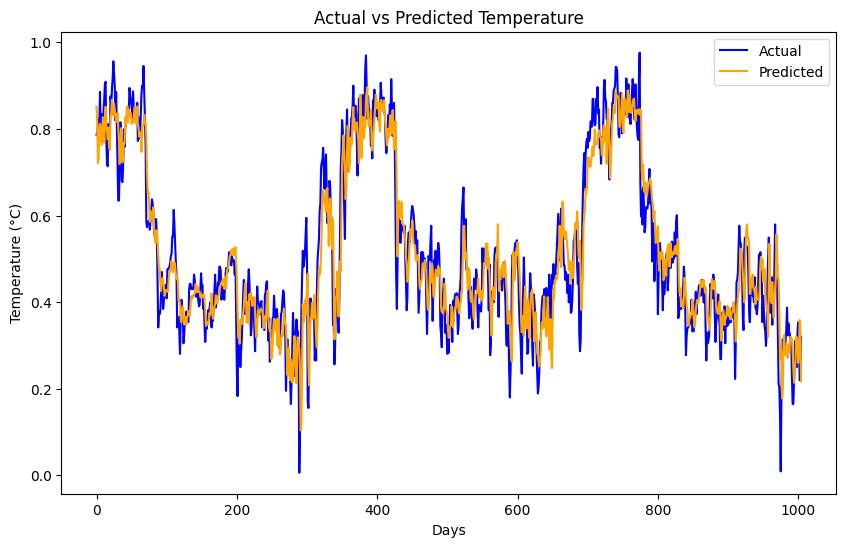

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [ ]:
def sequence_creating(data,seq_len,target_col = 'tempC'):
  X, y = [], []
  for i in range(len(data) - seq_len):
    X.append(data.iloc[i:i+seq_len, 1:].values)
    y.append(data.iloc[i+seq_len][target_col])
  return np.array(X), np.array(y)

sequence_length = 90

X_train, y_train = sequence_creating(train,sequence_length)
X_test, y_test = sequence_creating(test,sequence_length)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

model = Sequential()

model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, X_train.shape[2])))

model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100, activation='relu', return_sequences=False))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


model.summary()


history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

y_pred = model.predict(X_test)
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Actual', color='blue')
plt.plot(y_pred.flatten(), label='Predicted', color='orange')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

test.shape


y_pred = model.predict(X_test)


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test RMSE: ", rmse)
print("Test MAE: ", mae)
print("R²:", r2)

Test RMSE:  0.0739178233207736
Test MAE:  0.05614547779069774
R²: 0.8547451945984743


TEMPORAL FUSION TRANSFORMER MODEL

In [98]:
wf_daily_data.head()

,tempC,humidity,pressure,time_idx,group
date_time,,,,,
2009-01-01,0.314108,0.313762,0.711934,0,0
2009-01-02,0.283612,0.382809,0.759259,1,0
2009-01-03,0.317157,0.425552,0.806584,2,0
2009-01-04,0.289711,0.481916,0.751029,3,0
2009-01-05,0.308008,0.471113,0.662551,4,0


In [61]:
tft_data = pd.read_csv('out.csv')
tft_data.head()
print(type(tft_data))

<class 'pandas.core.frame.DataFrame'>


In [62]:
print(tft_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748 entries, 0 to 4747
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   tempC     4748 non-null   int64
 1   humidity  4748 non-null   int64
 2   pressure  4748 non-null   int64
 3   time_idx  4748 non-null   int64
 4   group     4748 non-null   int64
dtypes: int64(5)
memory usage: 185.6 KB
None


In [63]:
print(tft_data)

      tempC  humidity  pressure  time_idx  group
0        22        37      1012         0      0
1        22        44      1013         1      0
2        22        47      1014         2      0
3        22        52      1013         3      0
4        22        51      1011         4      0
...     ...       ...       ...       ...    ...
4743     23        44      1014      4743      0
4744     22        53      1013      4744      0
4745     21        53      1014      4745      0
4746     21        54      1015      4746      0
4747     22        48      1016      4747      0

[4748 rows x 5 columns]


In [64]:
from sklearn.preprocessing import MinMaxScaler

# Add time index
tft_data["time_idx"] = np.arange(len(tft_data))
print(type(tft_data))
# Scale numerical features
scaler = MinMaxScaler()
tft_data[["tempC", "humidity", "pressure"]] = scaler.fit_transform(tft_data[["tempC", "humidity", "pressure"]])

# Static covariate
tft_data["group"] = 0  # Only one time series

print(type(tft_data))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [65]:
# Split into training and validation
train_size = int(0.8 * len(tft_data))
train_data = tft_data.iloc[:train_size]
val_data = tft_data.iloc[train_size:]
print(type(train_size))
print(type(train_data))
print(type(val_data))

<class 'int'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [150]:
from pytorch_forecasting import TimeSeriesDataSet

# Define max lengths for encoder and decoder
max_encoder_length = 30  # Historical context
max_prediction_length = 7  # Forecast horizon

# Create TimeSeriesDataSet for training
training = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",  # Time index column
    target="tempC",  # Target column
    group_ids=["group"],  # Group identifier
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"],  # Known covariates (e.g., time_idx)
    time_varying_unknown_reals=["tempC", "humidity", "pressure"],  # Unknown covariates
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Create validation dataset from training
validation = TimeSeriesDataSet.from_dataset(training, val_data, predict=True, stop_randomization=True)

print(type(training))
print(type(validation))

<class 'pytorch_forecasting.data.timeseries.TimeSeriesDataSet'>
<class 'pytorch_forecasting.data.timeseries.TimeSeriesDataSet'>


In [163]:
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=0)

print(type(train_dataloader))
print(type(val_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [164]:
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

tft_model = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=16,  # Hidden layer size
    attention_head_size=4,  # Number of attention heads
    dropout=0.1,
    hidden_continuous_size=8,  # Size of continuous variable embeddings
    output_size=1,  # Output dimension (1 for regression)
    loss=QuantileLoss(),  # Loss function
    reduce_on_plateau_patience=4,  # Reduce LR on plateau
)

print(type(tft))

<class 'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer'>


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of 

In [165]:
from pytorch_lightning import Trainer

trainer = Trainer(
    max_epochs=30,  # Number of epochs
    gradient_clip_val=0.1,  # Gradient clipping
    accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Use GPU if available
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [60]:
# Train the model
#trainer.fit(lightning_tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


ValueError: optimizer got an empty parameter list

In [149]:

if len(tft_data) == 0:
    print("The list is empty")
else:
    print("The list is not empty")

The list is not empty


In [166]:
class WrappedTFT(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model  # Temporal Fusion Transformer (TFT) model

    def forward(self, x):
        # Forward pass through the TFT model
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
      # Extract inputs (x) and targets (y) from the batch
        x = batch[0]
        y = batch[1]

        # Move tensors to the same device
        if isinstance(x, dict):
            x = {key: value.to(self.device) for key, value in x.items() if isinstance(value, torch.Tensor)}
        else:
            x = x.to(self.device)

        y = y.to(self.device)

        # Forward pass through the model
        output = self.tft_model(x)
        print(output)

        # Calculate the loss
        loss = F.mse_loss(output, y)  # Replace with the appropriate loss function
        self.log("train_loss", loss, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        # Define optimizer and learning rate scheduler
        optimizer = torch.optim.Adam(self.tft_model.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]


In [104]:

tft1 = type(tft)
print(tft1)

<class 'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer'>


In [167]:
# Wrap the TFT model
lightning_tft = WrappedTFT(tft_data)

# Define the Trainer
trainer = Trainer(
    max_epochs=10,
    gradient_clip_val=0.1,
    devices=1,  # Use GPU
    accelerator="gpu"  # Ensure GPU usage
)

# Train the model
trainer.fit(lightning_tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


AttributeError: 'DataFrame' object has no attribute 'parameters'

In [87]:
from pytorch_lightning import Trainer

trainer = Trainer(
    max_epochs=30,  # Number of epochs
    gradient_clip_val=0.1,  # Gradient clipping
    accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Use GPU if available
)

trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `TemporalFusionTransformer`

In [27]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 33.5 MB/s eta 0:00:00


In [28]:
!pip install torch
import pandas as pd
import numpy as np
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss,RMSE
from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
from sklearn.preprocessing import MinMaxScaler
import torch
import pytorch_lightning as pl
wf_daily_data.head()
# Add a time index column
wf_daily_data['time_idx'] = np.arange(len(wf_daily_data))

# Add static and known covariates
#wf_daily_data['month'] = wf_daily_data.index.month  # Known covariate: month
wf_daily_data['group'] = 0  # Static covariate (only one series)

In [25]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(wf_daily_data[['tempC', 'humidity', 'pressure']])
wf_daily_data[['tempC', 'humidity', 'pressure']] = scaled_features

In [26]:

# Define the split ratio
train_ratio = 0.8

# Calculate the index for the split
split_idx = int(len(wf_daily_data) * train_ratio)

# Split the data
train_data = wf_daily_data.iloc[:split_idx]
val_data = wf_daily_data.iloc[split_idx:]

In [27]:
# Define encoder and decoder lengths
max_encoder_length = 30  # Length of historical context
max_prediction_length = 7  # Length of forecast horizon

# Create TimeSeriesDataSet
train_dataset = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",  # Time index column
    target="tempC",  # Target column
    group_ids=["group"],  # Group identifier
    max_encoder_length=max_encoder_length,  # Input sequence length
    max_prediction_length=max_prediction_length,  # Forecast length
    time_varying_known_reals=["time_idx"],  # Known covariates
    time_varying_unknown_reals=["tempC"],  # Unknown covariates
    add_relative_time_idx=True,  # Adds relative time index
    add_target_scales=True,  # Scale target variable
    add_encoder_length=True,  # Adds the length of encoder sequence
)

In [28]:

val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, val_data, predict=True, stop_randomization=True)
print(train_dataset)

TimeSeriesDataSet[length=3762](
	time_idx='time_idx',
	target='tempC',
	group_ids=['group'],
	weight=None,
	max_encoder_length=30,
	min_encoder_length=30,
	min_prediction_idx=0,
	min_prediction_length=7,
	max_prediction_length=7,
	static_categoricals=None,
	static_reals=None,
	time_varying_known_categoricals=None,
	time_varying_known_reals=['time_idx'],
	time_varying_unknown_categoricals=None,
	time_varying_unknown_reals=['tempC'],
	variable_groups=None,
	constant_fill_strategy=None,
	allow_missing_timesteps=False,
	lags=None,
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation=None,
	method_kwargs={}
),
	categorical_encoders={'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'encoder_length': StandardScaler(), 'tempC_center': StandardScaler(), 'tempC_scale': StandardScaler(), 'time_idx': StandardScaler(), 'relative_time_idx': St

In [29]:

# Create dataloaders
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=64, num_workers=0)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

In [30]:

# Initialize TFT model
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=0.01,
    hidden_size=16,  # Hidden layer size
    attention_head_size=4,  # Attention head size
    dropout=0.1,
    hidden_continuous_size=8,  # Size of continuous variable embeddings
    output_size=1,  # Number of outputs
    loss=RMSE(),  # Quantile loss for probabilistic forecasting
    #log_interval=10,
    reduce_on_plateau_patience=4,  # Reduce learning rate on plateau
)




/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of 

In [46]:
from typing import Any
import torch
from torch import Tensor
from torch.nn import functional as F
# ... (other imports) ...

class WrappedTFT(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model

    def forward(self, x):
        return self.tft_model(x)

    def training_step(self, batch: Any, batch_idx: int) -> Tensor:
        # Access the encoder inputs from the batch dictionary
        x, y = batch

        # Reshape the encoder inputs if necessary
        # x = x.view(x.size(0), -1) # Reshape if needed, check input shape of your TFT model

        # Run the TFT model forward pass
        output = self.tft_model(batch)

        # Calculate the loss using the TFT model's loss function
        loss = output["loss"]

        # Log the loss
        self.log("train_loss", loss)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]


In [48]:
from typing import Any
import torch
from torch import Tensor
from pytorch_lightning import LightningModule
from torch.nn import functional as F

class WrappedTFT(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model  # Ensure tft_model is compatible with PyTorch Lightning

    def forward(self, x: Any) -> Any:
        # Forward pass through the TFT model
        return self.tft_model(x)

    def training_step(self, batch: Any, batch_idx: int) -> Tensor:
        # Ensure batch has the expected structure
        x, y = batch  # If batch is a dict, use batch["x"], batch["y"]

        # Forward pass through the TFT model
        output = self.tft_model(x)

        # Calculate the loss
        loss = F.mse_loss(output, y)  # Example loss function; adjust based on model

        # Log the loss
        self.log("train_loss", loss, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        # Define optimizer and learning rate scheduler
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]



In [68]:
wf_daily_data.head()

,tempC,humidity,pressure,time_idx,group
date_time,,,,,
2009-01-01,0.314108,0.313762,0.711934,0,0
2009-01-02,0.283612,0.382809,0.759259,1,0
2009-01-03,0.317157,0.425552,0.806584,2,0
2009-01-04,0.289711,0.481916,0.751029,3,0
2009-01-05,0.308008,0.471113,0.662551,4,0


In [75]:
class WrappedTFT(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model  # Ensure tft_model is compatible with PyTorch Lightning

    def forward(self, x: Any) -> Any:
        # Forward pass through the TFT model
        return self.tft_model(x)
    def training_step(self, batch: Any, batch_idx: int) -> Tensor:
        # Extract tensors from the batch dictionary
        x = batch["x"]  # Features
        y = batch["y"]  # Target

        # Move all tensors in 'x' to the appropriate device
        for key in x:
          if isinstance(x[key], torch.Tensor):
            x[key] = x[key].to(self.device)

        # Move the target tensor to the appropriate device
        y = y.to(self.device)

        # Forward pass through the TFT model
        output = self.tft_model(x)

        # Calculate the loss (adjust based on model output type)
        loss = F.mse_loss(output, y)

        # Log the loss
        self.log("train_loss", loss, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        # Define optimizer and learning rate scheduler
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]


In [76]:
# Initialize your custom Lightning model with TFT
lightning_tft = WrappedTFT(tft)

# Define the trainer


from pytorch_lightning import Trainer

trainer = Trainer(max_epochs=30, gradient_clip_val=0.1, devices=1, accelerator="gpu")  # Use GPU if available


# Train the model
trainer.fit(lightning_tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 18.3 K | train
----------------------------------------------------------------
18.3 K    Trainable params
0         Non-trainable params
18.3 K    Total params
0.073     Total estimated model params size (MB)
280       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ut

TypeError: tuple indices must be integers or slices, not str

In [ ]:
#wf.set_index('date_time', inplace=True)
wf_seasons = wf[['precipMM','humidity','pressure']].resample('M').mean()
wf_seasons.head()

<ipython-input-192-031609a6c61e>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wf_seasons = wf[['precipMM','humidity','pressure']].resample('M').mean()


,precipMM,humidity,pressure
date_time,,,
2009-01-31,0.000000,38.258065,1013.915323
2009-02-28,0.000000,29.086310,1012.086310
2009-03-31,0.009274,30.844086,1010.573925
2009-04-30,0.001111,35.452778,1008.180556
2009-05-31,0.035753,55.303763,1006.811828


ARIMA MODEL FOR MANSOON SEASON

In [ ]:
wf_season_month = wf[['year','month','precipMM','humidity','pressure']]
wf_season_month.head()

,year,month,precipMM,humidity,pressure
date_time,,,,,
2009-01-01 00:00:00,2009,1,0.0,50,1013
2009-01-01 01:00:00,2009,1,0.0,46,1013
2009-01-01 02:00:00,2009,1,0.0,43,1013
2009-01-01 03:00:00,2009,1,0.0,40,1013
2009-01-01 04:00:00,2009,1,0.0,38,1013


In [ ]:
def get_season(month):
    if month in [3, 4, 5]:
        return "summer"
    elif month in [6,7,8]:
        return "rainy"
    elif month in [9,10,11,]:
        return "spring"
    elif month in [12, 1, 2]:
        return "winter"
    else:
        return "Unknown"
#ipython-input-366-2d1aba2fb642


In [ ]:
wf_season_month['season'] = wf_season_month['month'].apply(get_season)
wf_season_month.tail()

<ipython-input-196-7c8d05128f06>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf_season_month['season'] = wf_season_month['month'].apply(get_season)


,year,month,precipMM,humidity,pressure,season
date_time,,,,,,
2021-12-31 19:00:00,2021,12,0.0,42,1016,winter
2021-12-31 20:00:00,2021,12,0.0,43,1017,winter
2021-12-31 21:00:00,2021,12,0.0,44,1018,winter
2021-12-31 22:00:00,2021,12,0.0,46,1017,winter
2021-12-31 23:00:00,2021,12,0.0,47,1017,winter


In [ ]:
mansoon_data = wf_season_month[wf_season_month['season'] == 'rainy']
mansoon_data.head()

,year,month,precipMM,humidity,pressure,season
date_time,,,,,,
2009-06-01 00:00:00,2009,6,0.0,90,1007,rainy
2009-06-01 01:00:00,2009,6,0.0,91,1007,rainy
2009-06-01 02:00:00,2009,6,0.0,92,1007,rainy
2009-06-01 03:00:00,2009,6,0.0,94,1007,rainy
2009-06-01 04:00:00,2009,6,0.0,84,1007,rainy


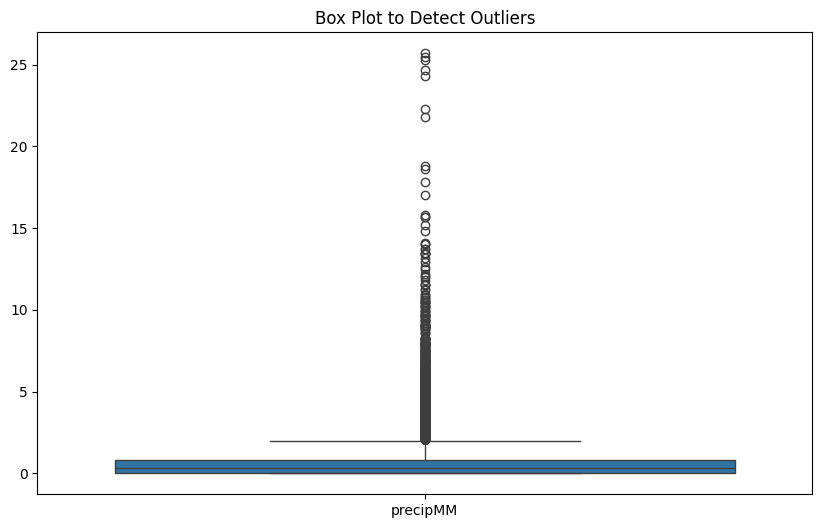

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mansoon_data[['precipMM']])#, 'humidity']])
plt.title('Box Plot to Detect Outliers')
plt.show()

Q1 = mansoon_data['precipMM'].quantile(0.25)
Q3 = mansoon_data['precipMM'].quantile(0.75)
IQR = Q3 - Q1

#Q5 = wf['humidity'].quantile(0.25)
#Q7 = wf['humidity'].quantile(0.75)
#IQR1 = Q7 - Q5

outliers_precipMM = mansoon_data[(mansoon_data['precipMM'] < (Q1 - 1.5 * IQR)) | (mansoon_data['precipMM'] > (Q3 + 1.5 * IQR))]

In [ ]:
print("Number of outliers in Temperature:", len(outliers_precipMM))

Number of outliers in Temperature: 2142


In [ ]:
print("Original DataFrame shape:", mansoon_data.shape)
print(outliers_precipMM[['year', 'precipMM']])

Original DataFrame shape: (28704, 6)
                     year  precipMM
date_time                          
2009-06-06 15:00:00  2009       5.5
2009-06-20 06:00:00  2009       2.1
2009-06-20 08:00:00  2009       3.1
2009-06-20 09:00:00  2009       4.2
2009-06-20 10:00:00  2009       2.1
...                   ...       ...
2021-08-31 07:00:00  2021       3.8
2021-08-31 08:00:00  2021       3.4
2021-08-31 09:00:00  2021       3.3
2021-08-31 10:00:00  2021       3.2
2021-08-31 11:00:00  2021       2.8

[2142 rows x 2 columns]


In [ ]:
wf_M= mansoon_data[(mansoon_data['precipMM'] >= (Q1 - 1.5 * IQR)) & (mansoon_data['precipMM'] <= (Q3 + 1.5 * IQR))]
wf_M.tail()

,year,month,precipMM,humidity,pressure,season
date_time,,,,,,
2021-08-31 19:00:00,2021,8,0.7,83,1007,rainy
2021-08-31 20:00:00,2021,8,0.5,85,1008,rainy
2021-08-31 21:00:00,2021,8,0.5,86,1008,rainy
2021-08-31 22:00:00,2021,8,0.4,87,1008,rainy
2021-08-31 23:00:00,2021,8,0.5,87,1008,rainy


Number of outliers in Temperature: 26562
                     year  month  precipMM  humidity  pressure season
date_time                                                            
2009-06-01 00:00:00  2009      6       0.0        90      1007  rainy
2009-06-01 01:00:00  2009      6       0.0        91      1007  rainy
2009-06-01 02:00:00  2009      6       0.0        92      1007  rainy
2009-06-01 03:00:00  2009      6       0.0        94      1007  rainy
2009-06-01 04:00:00  2009      6       0.0        84      1007  rainy


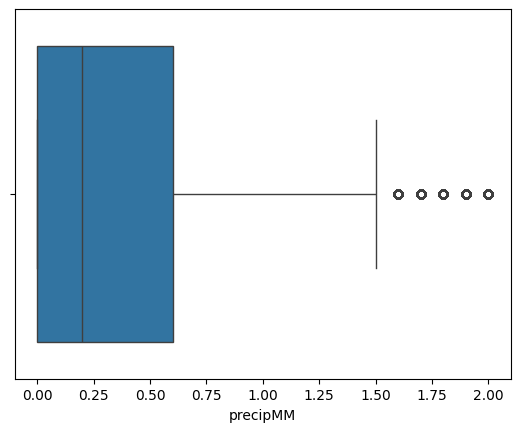

In [ ]:
sns.boxplot(x=wf_M['precipMM'])
print("Number of outliers in Temperature:", len(wf_M))
print(wf_M.head())


In [ ]:
wf_mansoon = wf_M[['precipMM','humidity','pressure']].resample('D').mean()
wf_mansoon.head()

,precipMM,humidity,pressure
date_time,,,
2009-06-01,0.087500,67.375000,1007.083333
2009-06-02,0.150000,67.958333,1008.000000
2009-06-03,0.066667,68.375000,1008.958333
2009-06-04,0.133333,72.625000,1007.333333
2009-06-05,0.170833,76.041667,1005.000000


In [ ]:
# Scale the selected columns and store the result in a temporary variable
scaled_data = scaler.fit_transform(wf_mansoon[['precipMM','humidity','pressure']])

# Assign the scaled values back to the original columns
wf_mansoon[['precipMM','humidity','pressure']] = scaled_data

In [ ]:
wf_mansoon['precipMM_lag_1'] = wf_mansoon['precipMM'].shift(1)
wf_mansoon['humidity_lag_1'] = wf_mansoon['humidity'].shift(1)

In [ ]:
missing_values = wf_mansoon.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 precipMM          0
humidity          0
pressure          0
precipMM_lag_1    1
humidity_lag_1    1
dtype: int64


In [ ]:
wf_mansoon.fillna(method = 'bfill',inplace=True)
wf_mansoon.head()

<ipython-input-236-38110a24eef2>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wf_mansoon.fillna(method = 'bfill',inplace=True)


,precipMM,humidity,pressure,precipMM_lag_1,humidity_lag_1
date_time,,,,,
2009-06-01,0.046543,0.324733,0.691039,0.046543,0.324733
2009-06-02,0.079787,0.337189,0.759697,0.046543,0.324733
2009-06-03,0.035461,0.346085,0.831476,0.079787,0.337189
2009-06-04,0.070922,0.436833,0.709764,0.035461,0.346085
2009-06-05,0.090869,0.509786,0.534998,0.070922,0.436833


In [ ]:
missing_values = wf_mansoon.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 precipMM          0
humidity          0
pressure          0
precipMM_lag_1    0
humidity_lag_1    0
dtype: int64


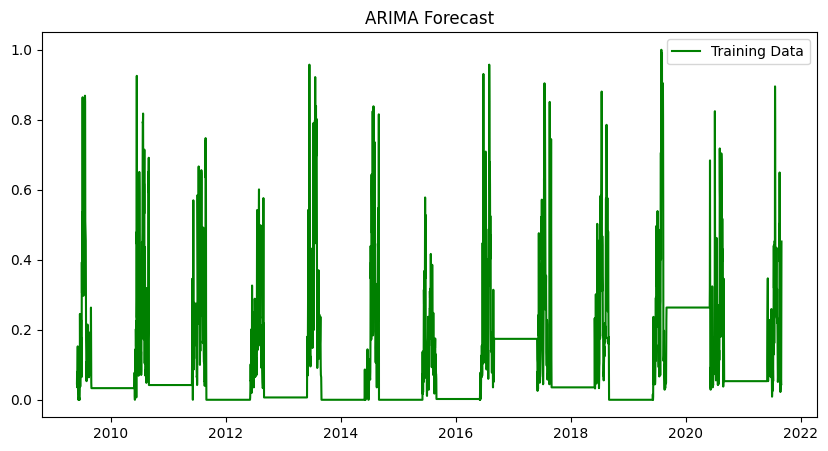

In [ ]:
# Split into training and testing setstrain_size = int(len(wf_mansoon) * 0.8)  # 80% for training
train_m = wf_mansoon.iloc[:train_size]
test_m = wf_mansoon.iloc[train_size:]
train_m = wf_mansoon[wf_mansoon.index <= pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object
test_m = wf_mansoon[wf_mansoon.index > pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object
plt.figure(figsize=(10, 5))
plt.plot(wf_mansoon['precipMM'], label="Training Data", color="green")
#plt.plot(test_m['precipMM'], label="Validation Data", color="green")
#plt.plot(forecast_index, forecast, label="Forecast", color="red")
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

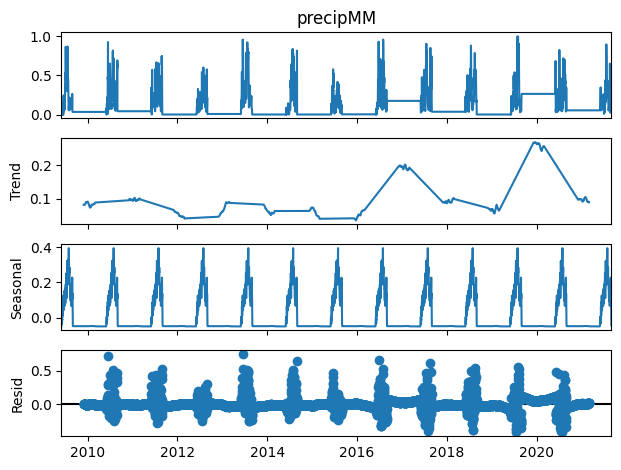

ADF Statistic: -5.667844086985084
p-value: 9.064904339519046e-07
The series is stationary.


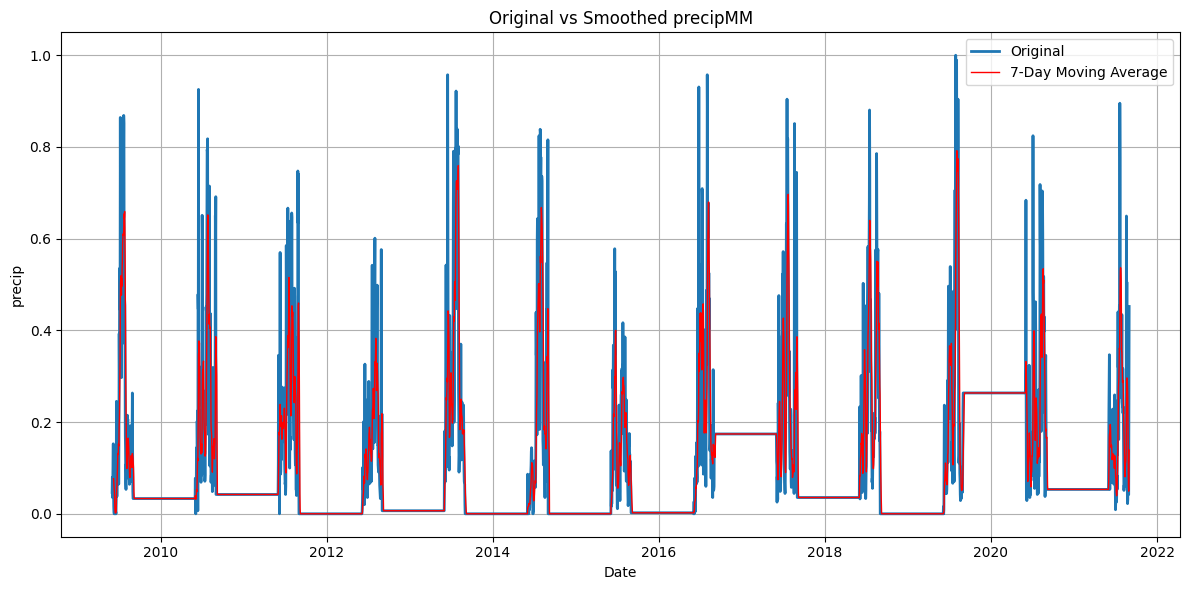

<Figure size 1200x600 with 0 Axes>

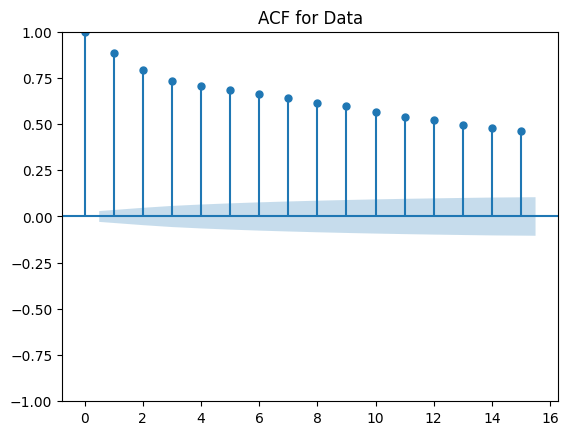

<Figure size 1200x600 with 0 Axes>

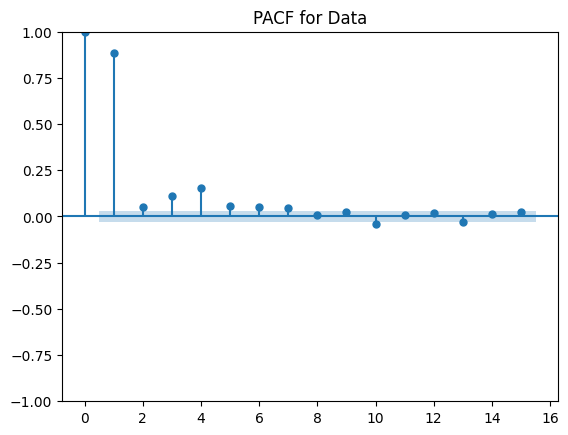

In [ ]:

precipMM_result = seasonal_decompose(wf_mansoon['precipMM'], model='additive', period=365)
precipMM_result.plot()
plt.show()
check_stationarity(wf_mansoon['precipMM'])
precipMM_rolling = wf_mansoon['precipMM'].rolling(window=7).mean()
plt.figure(figsize=(12, 6))
plt.plot(wf_mansoon.index, wf_mansoon['precipMM'], label='Original', linewidth=2)
plt.plot(wf_mansoon.index, precipMM_rolling, label='7-Day Moving Average', color='red', linewidth=1)
plt.title('Original vs Smoothed precipMM')
plt.xlabel('Date')
plt.ylabel('precip')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(wf_mansoon['precipMM'], lags=15)
plt.title('ACF for Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(wf_mansoon['precipMM'], lags=15)
plt.title('PACF for Data')
plt.show()

In [ ]:

from pmdarima import auto_arima

auto_model = auto_arima(train_m['precipMM'],
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        d=None,
                        seasonal=False,
                        stepwise=True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        max_order=None,
                        information_criterion='aic'
                        )


print(auto_model.summary())

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2573.387, Time=0.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-8920.426, Time=0.63 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5566.034, Time=2.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-8931.232, Time=3.35 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-8981.801, Time=2.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-9100.963, Time=1.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-9112.426, Time=1.32 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-9127.003, Time=4.69 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-9125.119, Time=6.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-9121.156, Time=5.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-9126.888, Time=1.67 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-9130.885, Time=18.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-9144.364, Time=11.02 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-9125.287, Time=11.76 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-9127.950, Time=1.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-9144.074, Time=12.95 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-9021.099, Time=0.80 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-9130.845, Time=10.73 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-9136.310, Time=0.97 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=-9140.464, Time=11.58 sec

Best model:  ARIMA(4,0,1)(0,0,0)[0] intercept
Total fit time: 107.866 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3653
Model:               SARIMAX(4, 0, 1)   Log Likelihood                4579.182
Date:                Wed, 01 Jan 2025   AIC                          -9144.364
Time:                        19:56:02   BIC                          -9100.941
Sample:                    06-01-2009   HQIC                         -9128.901
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0033      0.002      1.929      0.054    -5.2e

In [ ]:
m_model = ARIMA(train_m['precipMM'], order=(4, 0, 1),exog=train_m[['humidity', 'pressure','precipMM_lag_1','humidity_lag_1']])
m_model_fit = m_model.fit()
print(m_model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               precipMM   No. Observations:                 3653
Model:                 ARIMA(4, 0, 1)   Log Likelihood                5103.990
Date:                Wed, 01 Jan 2025   AIC                         -10185.980
Time:                        20:15:56   BIC                         -10117.744
Sample:                    06-01-2009   HQIC                        -10161.680
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0197      0.004      4.794      0.000       0.012       0.028
humidity           0.6965      0.008     90.522      0.000       0.681       0.712
pressure          -0.0424      0.006

In [ ]:
m_forecast_steps = len(test_m)
m_forecast = m_model_fit.forecast(steps=m_forecast_steps,exog=test_m[['humidity', 'pressure','precipMM_lag_1','humidity_lag_1']])
m_forecast_index = pd.date_range(start=test_m.index[0] + pd.Timedelta(days=1), periods=m_forecast_steps, freq='D')


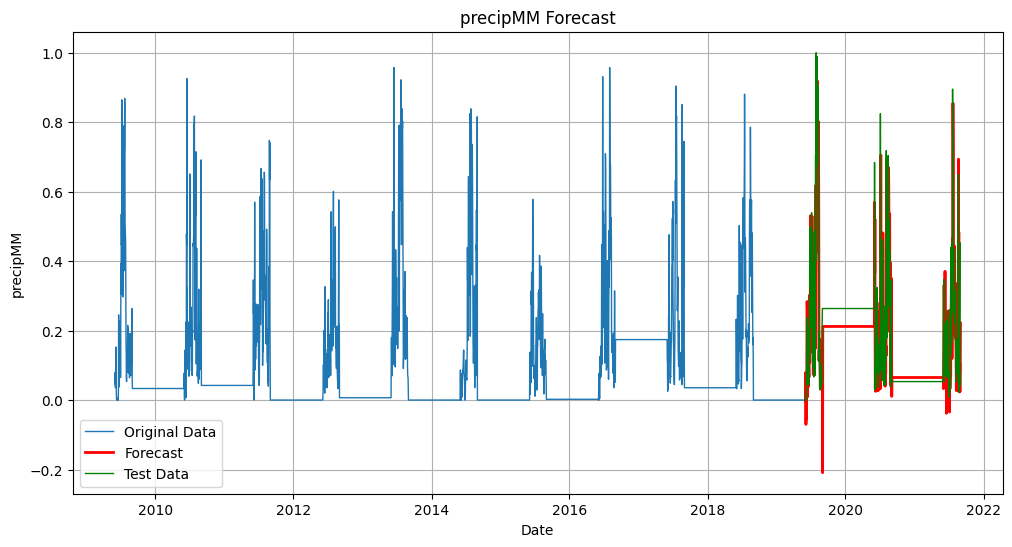

In [ ]:


#outliers_humidity = wf[(wf['humidity'] < (Q5 - 1.5 * IQR)) | (wf['humidity'] > (Q7 + 1.5 * IQR))]

#print("Number of outliers in Humidity:", len(outliers_humidity))

#print(outliers_humidity[['year', 'humidity']])

plt.figure(figsize=(12, 6))
plt.plot(train_m.index, train_m['precipMM'], label='Original Data', linewidth=1)
plt.plot(m_forecast_index, m_forecast, label='Forecast', color='red', linewidth=2)
plt.plot(test_m.index, test_m['precipMM'], label='Test Data', color='green', linewidth=1)
plt.title('precipMM Forecast')
plt.xlabel('Date')
plt.ylabel('precipMM')
plt.legend()
plt.grid()
plt.show()


In [ ]:
test_m.shape

(822, 5)

In [ ]:
m_forecast.shape

(822,)

In [ ]:

mae = mean_absolute_error(test_m['precipMM'], m_forecast)
print("MAE:", mae)
rmse = np.sqrt(mean_squared_error(test_m['precipMM'], m_forecast))
print("RMSE:", rmse)
r2 = r2_score(test_m['precipMM'], m_forecast)
print("R²:", r2)

MAE: 0.05201742303303912
RMSE: 0.0818816014136983
R²: 0.7121941630809965


prophet

In [ ]:
wf_mansoon_m = pd.DataFrame(wf_mansoon)
wf_mansoon_m.drop(columns=['precipMM_lag_1', 'humidity_lag_1'],inplace = True)
wf_mansoon_m.head()


,precipMM,humidity,pressure
date_time,,,
2009-06-01,0.046543,0.324733,0.691039
2009-06-02,0.079787,0.337189,0.759697
2009-06-03,0.035461,0.346085,0.831476
2009-06-04,0.070922,0.436833,0.709764
2009-06-05,0.090869,0.509786,0.534998


In [ ]:
wf_mansoon_m['ds'] = pd.to_datetime(wf_mansoon_m.index)
wf_mansoon_m['y'] = wf_mansoon_m['precipMM']
wf_mansoon_m.head()

#train_size = int(len(wf_mansoon_m) * 0.8)  # 80% for training
#train_m = wf_mansoon_m.iloc[:train_size]
#test_m = wf_mansoon_m.iloc[train_size:]

train_m_p = wf_mansoon_m[wf_mansoon_m.index <= pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object
test_m_p = wf_mansoon_m[wf_mansoon_m.index > pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object

In [ ]:
m_p_model = Prophet(interval_width = 0.68)
m_p_model.fit(train_m_p)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppvy8jwku/4kbx3y7t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppvy8jwku/sq_q1iad.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54385', 'data', 'file=/tmp/tmppvy8jwku/4kbx3y7t.json', 'init=/tmp/tmppvy8jwku/sq_q1iad.json', 'output', 'file=/tmp/tmppvy8jwku/prophet_model4400o78i/prophet_model-20250101211247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
m_p_forecast_steps=len(test_m_p)
m_p_future = m_p_model.make_future_dataframe(periods=forecast_steps,freq='D')

In [ ]:
m_p_forecast = m_p_model.predict(m_p_future)
m_p_forecast[['ds', 'yhat', 'yhat_lower','yhat_upper', 'trend','trend_lower', 'trend_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
4743,2022-05-27,-0.191134,-0.313789,-0.055803,-0.133572,-0.214923,-0.049065
4744,2022-05-28,-0.182178,-0.312148,-0.061396,-0.133728,-0.215182,-0.049244
4745,2022-05-29,-0.173978,-0.312450,-0.049925,-0.133885,-0.215442,-0.049422
4746,2022-05-30,-0.167439,-0.299274,-0.029699,-0.134041,-0.215701,-0.049601
4747,2022-05-31,-0.159028,-0.285245,-0.026325,-0.134197,-0.215960,-0.049798


In [ ]:
y_true = wf_mansoon_m['y'].values  # Replace 'y' with your target column name
y_pred = m_p_forecast['yhat'][:len(y_true)].values

In [ ]:
wf_prophet_m = pd.concat([train_m_p,test_m_p])

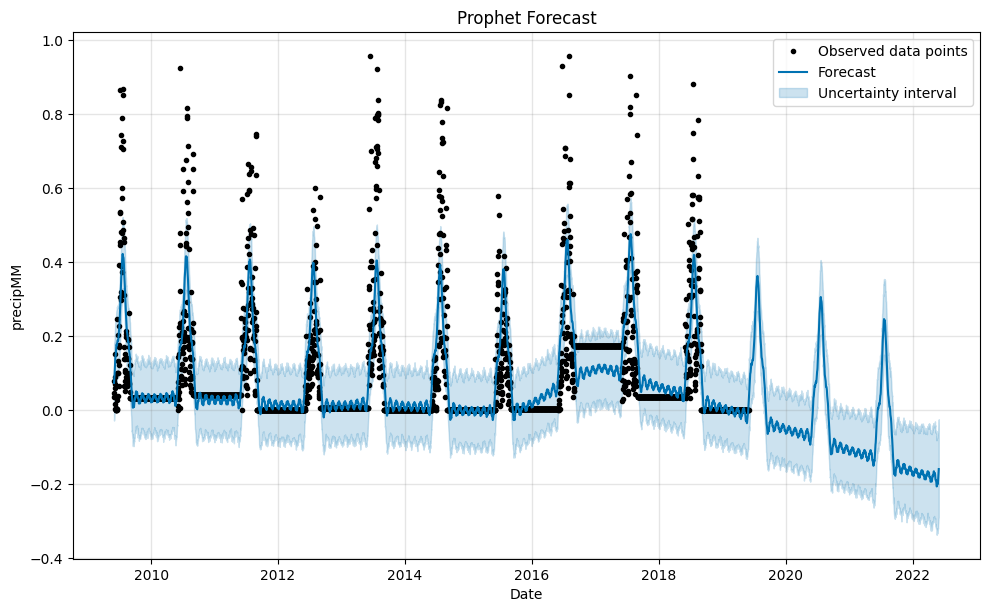

In [ ]:
prophet_plot_2 = m_p_model.plot(m_p_forecast, include_legend=True)
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("precipMM")
plt.show()

In [ ]:

# Merge actual and forecasted data
m_p_forecast_actual = pd.merge(test_m_p, m_p_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

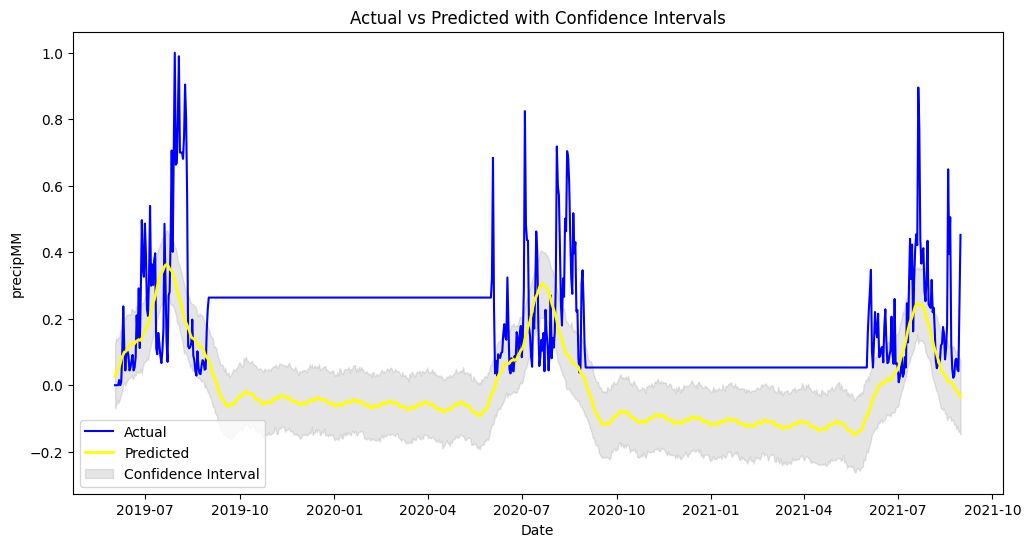

,yhat
0,0.073928
1,0.083423
2,0.087278
3,0.094186
4,0.104407
...,...
4743,-0.191134
4744,-0.182178
4745,-0.173978
4746,-0.167439


In [ ]:


# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(m_p_forecast_actual['ds'], m_p_forecast_actual['y'], label='Actual', color='blue')
plt.plot(m_p_forecast_actual['ds'], m_p_forecast_actual['yhat'], label='Predicted', color='yellow',linewidth=2)
plt.fill_between(m_p_forecast_actual['ds'],
                 m_p_forecast_actual['yhat_lower'],
                 m_p_forecast_actual['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title("Actual vs Predicted with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("precipMM")
plt.legend()
plt.show()

m_p_forecast['yhat']

In [ ]:
# code
# Ensure y_pred has the same length as wf_prophet_m["y"]
y_pred_subset = m_p_forecast['yhat'][:len(wf_prophet_m["y"])]

In [363]:
# code
print("Mean Squared Error (MSE):", mean_squared_error(y_true = y_true, y_pred = y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = y_true, y_pred = y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_true = y_true, y_pred = y_pred)))
print("R-squared (R²):", r2_score(y_true = y_true, y_pred = y_pred))

Mean Squared Error (MSE): 0.018653041764115353
Mean Absolute Error (MAE): 0.08164523749839185
Root Mean Squared Error (RMSE): 0.1365761390731022
R-squared (R²): 0.21037114814624358


tunning

In [381]:
from prophet.diagnostics import cross_validation, performance_metrics
from itertools import product

In [377]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],  # Trend flexibility
    'seasonality_mode': ['additive', 'multiplicative']  # Additive or multiplicative seasonality
}


In [ ]:
best_rmse = float("inf")
best_params = None

# Grid search
for cp_scale, season_mode in product(
    param_grid['changepoint_prior_scale'],
    param_grid['seasonality_mode']
):
    # Initialize model with parameters
    model = Prophet(
        changepoint_prior_scale=cp_scale,
        seasonality_mode=season_mode
    )

    # Fit the model
    model.fit(train_m_p)

    # Perform cross-validation
    df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='365 days')

    # Calculate metrics
    df_p = performance_metrics(df_cv)



In [387]:
# Retrain on full training data with best parameters
final_model = Prophet(
    changepoint_prior_scale=cp_scale,
    seasonality_mode=season_mode
)
final_model.fit(train_m_p)

# Predict on test data
future = final_model.make_future_dataframe(periods=len(test_m_p))
forecast = final_model.predict(future)

# Evaluate performance
y_true = wf_mansoon_m['y'].values
y_pred = forecast['yhat'][-len(y_true):].values

print("Test RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("Test MAE:", mean_absolute_error(y_true, y_pred))
print("R² Score:", r2_score(y_true, y_pred))


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppvy8jwku/5qwyhk_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppvy8jwku/1es98tco.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4400', 'data', 'file=/tmp/tmppvy8jwku/5qwyhk_v.json', 'init=/tmp/tmppvy8jwku/1es98tco.json', 'output', 'file=/tmp/tmppvy8jwku/prophet_model0y0lme9s/prophet_model-20250102013302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test RMSE: 0.11491028862383318
Test MAE: 0.06695654869597667
R² Score: 0.44102655461052176
